## Recommendation (collaborative filtering) example

In [1]:
# pyspark specific imports
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col

# other python imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

/home/ec2-user/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from pyspark.sql.functions import *

In [3]:
sc

<SparkContext master=spark://ec2-52-3-235-146.compute-1.amazonaws.com:7077 appName=PySparkShell>

### Load data


GroupLens Research has collected and made available rating data sets from the MovieLens web site. The data sets were collected over various periods of time, depending on the size of the set. They can be found here.

In our case, we will use the latest datasets:

* Small: 100,000 ratings and 2,488 tag applications applied to 8,570 movies by 706 users by 4/2015.
* Full: 21,000,000 ratings and 470,000 tag applications applied to 27,000 movies by 230,000 users by 4/2015.

Data was previously downloaded to master and sent to S3 bucket 

In [4]:
# load ratings
ratings = spark.read.option("sep", ",")\
            .option("header", "true")\
            .csv(
                 "s3a://jalg-data/data/public-data-sets/movielens/ml-latest-small/ratings.csv"
                 #"s3a://jalg-data/data/public-data-sets/movielens/ml-latest/ratings.csv"
                 , inferSchema=True)
ratings = ratings.cache()

In [5]:
print(ratings.head())
print(ratings.describe(["userId", "movieId", "rating", "timestamp"]).show())
print('uniquer users', ratings.select('userId').dropDuplicates().count())
print('uniquer items', ratings.select('movieId').dropDuplicates().count())

Row(userId=1, movieId=1, rating=4.0, timestamp=964982703)
+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+

None
('uniquer users', 610)
('uniquer items', 9724)


In [6]:
# load movie titles
movies = spark.read.option("sep", ",")\
            .option("header", "true")\
            .csv(
                 "s3a://jalg-data/data/public-data-sets/movielens/ml-latest-small/movies.csv"
                 #"s3a://jalg-data/data/public-data-sets/movielens/ml-latest/movies.csv"
                 , inferSchema=True)
movies = movies.cache()

In [7]:
# print first n movies
n=2
print(movies.head(n))

[Row(movieId=1, title=u'Toy Story (1995)', genres=u'Adventure|Animation|Children|Comedy|Fantasy'), Row(movieId=2, title=u'Jumanji (1995)', genres=u'Adventure|Children|Fantasy')]


## Pre-Process data¶

In [8]:
(training, test) = ratings.randomSplit([0.8, 0.2])

### Train matrix factorization model¶

Build the recommendation model using Spark  Collaborative Filtering implementation 
using Alternating Least Squares (ALS)  on the training data.

In [9]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
# K and lambda values were obtained with a sampling subset made on other notebook

K=100
lmbda = 0.147945
als = ALS(regParam=lmbda, rank=K, maxIter=20, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", numUserBlocks=10, numItemBlocks=10)

stime = time.time()
model = als.fit(training)
etime = time.time()

In [10]:

print('Elapsed time', etime-stime)

('Elapsed time', 136.13564705848694)


## Predictions and model exploration¶

In [11]:
# Evaluate the model by computing the RMSE on train and test datasets
predictions = model.transform(training)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse_train = evaluator.evaluate(predictions)

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse_test = evaluator.evaluate(predictions)

In [12]:
#Train RMSE =  0.6356150490826092 #.4496 with small 
#Test RMSE =  0.8453643678422643  #.8750
print("Train RMSE = ", str(rmse_train))
print("Test RMSE = ", str(rmse_test))

('Train RMSE = ', '0.586345561129')
('Test RMSE = ', '0.873013713849')


In [13]:
def explore_user(uID):
    userRecs(uID)

In [14]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
# movieRecs = model.recommendForAllItems(10)
userRecs.cache()

DataFrame[userId: int, recommendations: array<struct<movieId:int,rating:float>>]

In [15]:
def movie_names(mid):
    #print(type(movies.where(col("movieId") == mid).select(col("title")).collect()))
    return movies.where(col("movieId") == mid).select(col("title")).collect()[0][0]

def movie_genres(mid):
    #print(type(movies.where(col("movieId") == mid).select(col("title")).collect()))
    return movies.where(col("movieId") == mid).select(col("genres")).collect()[0][0]

In [ ]:
# Lets explore some valid userId values
training.groupBy('userId')\
        .agg(
         count(lit(1)).alias("Num Of Records")
        )\
        .show(5)

+------+--------------+
|userId|Num Of Records|
+------+--------------+
| 52697|            20|
| 53191|            33|
| 53565|            89|
| 53634|           532|
| 53691|           323|
+------+--------------+
only showing top 5 rows



In [16]:
training.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
+------+-------+------+---------+
only showing top 5 rows



In [17]:
uID = 481 #516

training_user = training.where(training.userId == uID).select("movieId", "rating").collect()
print('Training set for user %d' % uID)
for i,movie in enumerate(training_user):
    #rating = training_user.where(training_user.movieId == movie.movieId).select("rating").collect()
    print('\t %s. %s %d ' % (movie_names(movie.movieId), movie_genres(movie.movieId), movie.rating))
print('') # skip line

reco_users = userRecs.where(userRecs.userId == uID).select("recommendations.movieId", "recommendations.rating").collect()[0]
print('Recommendations for user %d' % uID)
for i,mid in enumerate(reco_users[0]):
    print('\t %d. %s (%s) (predicted rating: %.3f)' % (i+1,movie_names(mid),movie_genres(mid), reco_users[1][i]))
    

Training set for user 481
	 Fly Away Home (1996). Adventure|Children 3 
	 English Patient, The (1996). Drama|Romance|War 4 
	 Scream (1996). Comedy|Horror|Mystery|Thriller 2 
	 Dante's Peak (1997). Action|Thriller 2 
	 Rosewood (1997). Action|Drama 4 
	 Saint, The (1997). Action|Romance|Sci-Fi|Thriller 3 
	 Crash (1996). Drama|Thriller 1 
	 Liar Liar (1997). Comedy 2 
	 Contact (1997). Drama|Sci-Fi 3 
	 G.I. Jane (1997). Action|Drama 3 
	 George of the Jungle (1997). Children|Comedy 1 
	 Excess Baggage (1997). Adventure|Romance 2 
	 Edge, The (1997). Adventure|Drama 3 
	 L.A. Confidential (1997). Crime|Film-Noir|Mystery|Thriller 5 
	 Kiss the Girls (1997). Crime|Drama|Mystery|Thriller 3 
	 Gattaca (1997). Drama|Sci-Fi|Thriller 3 
	 Bean (1997). Comedy 2 
	 Rainmaker, The (1997). Drama 2 
	 Jackal, The (1997). Action|Thriller 2 
	 Amistad (1997). Drama|Mystery 3 
	 Midnight in the Garden of Good and Evil (1997). Crime|Drama|Mystery 2 
	 Jackie Brown (1997). Crime|Drama|Thriller 4 

Reco

## Making client clusters

Let's get client groups on the reduced movie space. This will give groups of users with similar movie preferences.

In [22]:
# Fist explore the model schema. 

model.userFactors.printSchema()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



In [23]:
# To fit k means we need to transform the struct column (array of floats)
# to make it a VectorUDT() fittable on k means model
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())
userFactors = model.userFactors.select("id", to_vector("features").alias("features"))
userFactors.show(2)
userFactors.printSchema()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.1626528650522...|
| 20|[-0.0171219650655...|
+---+--------------------+
only showing top 2 rows



In [51]:
from pyspark.ml.clustering import KMeans
# from pyspark.ml.evaluation import ClusteringEvaluator #←Available from Spark2.4 otherwisee
# "cannnot import name Clustering Evaluator"

distances = []
K = [i for i in range(2,16,2)]
# Trains a k-means model.
for k in K: #
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(userFactors)
    # Evaluate clustering by computing Within Set Sum of Squared Errors.
    wssse = model.computeCost(userFactors)
    distances.append(wssse)
    print("K=%s Within Set Sum of Squared Errors = %s" % (i, str(wssse)))

K=14 Within Set Sum of Squared Errors = 588.96014009
K=14 Within Set Sum of Squared Errors = 549.870534171
K=14 Within Set Sum of Squared Errors = 527.983063205
K=14 Within Set Sum of Squared Errors = 517.364766303
K=14 Within Set Sum of Squared Errors = 507.744570397
K=14 Within Set Sum of Squared Errors = 493.79450532
K=14 Within Set Sum of Squared Errors = 490.873107739


In [46]:
%matplotlib inline

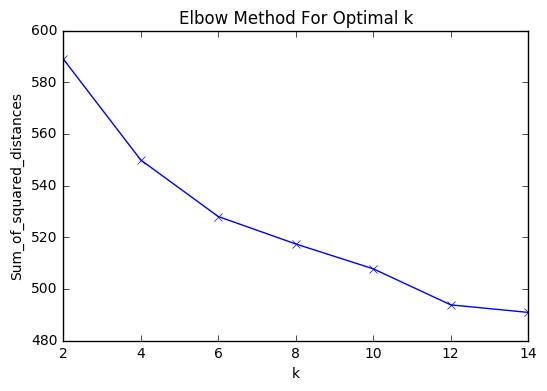

In [52]:

plt.plot(K, distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [31]:
# Shows the result.
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-0.27027453 -0.01456134 -0.12033038  0.21053932 -0.13377108  0.08097948
 -0.17182734 -0.11293676  0.4611842  -0.23818222  0.17638986 -0.16622032
  0.14259084  0.0085197   0.07407033  0.1821133   0.03464363  0.06855111
  0.0052641   0.18643391  0.01468537 -0.18681749  0.11970921  0.02300163
 -0.21754491 -0.11392811  0.42547616  0.10252684  0.05140364  0.04453696
 -0.20219906  0.18618549 -0.07564795 -0.04380206 -0.4276505  -0.26850009
  0.35790176 -0.19487912  0.1410609  -0.13137088 -0.18829244  0.0265753
  0.2812695   0.12651698  0.14277859  0.06724467 -0.04974328  0.17051954
  0.07813969  0.03645741 -0.04688335  0.26176309  0.23350756 -0.02041319
  0.02175639  0.06449949 -0.16387386 -0.28332625  0.07292656 -0.03923635
 -0.36586827 -0.15771603  0.173909    0.14804051  0.02275693  0.1001347
 -0.08321379 -0.17220358 -0.28324984 -0.11226808  0.42412092  0.20207809
  0.05582198 -0.11481481 -0.18123334 -0.27164248  0.22442399 -0.25274109
 -0.10768397  0.17516573  0.1092060

In [34]:
[i.shape for i in centers]

[(100,), (100,), (100,), (100,), (100,)]

In [ ]:
model_pd = model.itemFactors.count()

In [ ]:
model_pd.tail()